# Classify
* Load the feature matrix prepared in previous notebook
* Compute a baseline
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network
* Save the fitted classifier

In [35]:
import numpy as np
from os.path import join
from sklearn.dummy import DummyClassifier
import pickle
import pandas as pd
import random
import time

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, RandomBrightness
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

Global variables

In [41]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [18]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 3

# define results matrix
eval_pd = pd.DataFrame(columns=['model', 'accuracy', 'CPU_time'])

Load the feature matrix prepared in previous notebook

In [60]:
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

## Compute a baseline

In [61]:
# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it to the train data
dummy.fit(X, y)
accuracy = dummy.score(X, y)
eval_pd.loc[len(eval_pd)] = {'model': 'dummy' , 'accuracy': accuracy, 'CPU_time': dtime}
print(f"The baseline accuracy is {accuracy:0.2f}")

The baseline accuracy is 0.46


## Classify using transfer learning
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network

In [21]:
# one-hot encode the labels
classes, y_classes = np.unique(y, return_inverse=True)
y = to_categorical(y_classes, num_classes=output_classes)

Display some images for checking

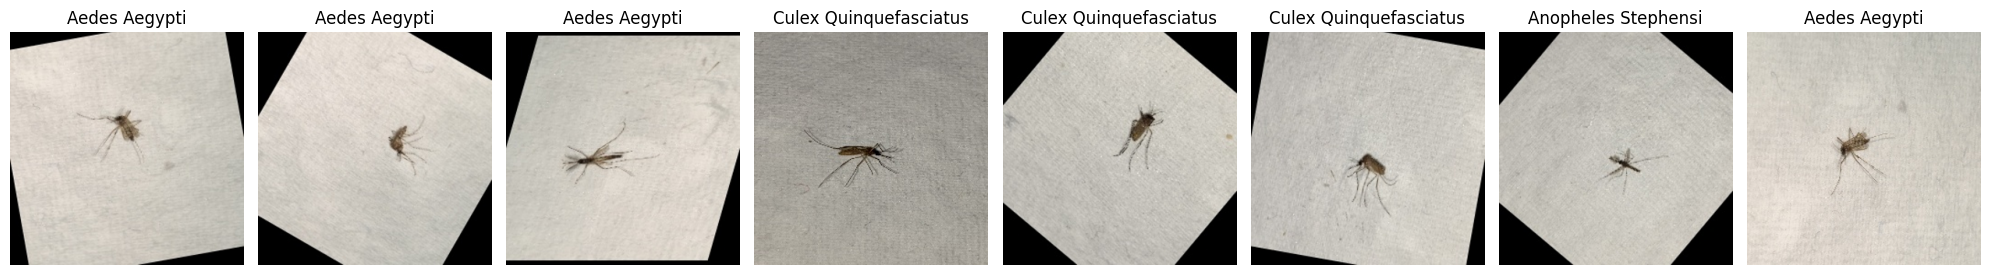

In [23]:
check_images = 8
idx = random.sample(range(len(X)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    class_name = classes[list(y[id]).index(1)]
    ax[i].set_title(class_name)
    ax[i].axis('off')
plt.tight_layout()
plt.show();

Load pre-trained model

In [25]:
backbone = tf.keras.applications.MobileNetV3Small(
    input_shape=input_shape,
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)
backbone.trainable = False

Define the local model

In [26]:
input = Input(shape=(input_width, input_height, input_depth))

x = backbone(input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)

output = Dense(output_classes, activation='softmax')(x)

model = Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 10, 10, 576)    │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,531 (4.45 MB)

 Trainable params: 724,483 (2.76 MB)

 Non-trainable params: 443,048 (1.69 MB)

In [27]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

Fit the model

In [29]:
%%time

callback = EarlyStopping(monitor='val_accuracy', patience=5)
# Fit model
history = model.fit(
    x=X, y=y,
    validation_split=0.2,
    batch_size=32, epochs=20,
    callbacks=[callback]
)

Epoch 1/20


/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8117 - loss: 0.4534 - val_accuracy: 0.7020 - val_loss: 0.5496
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9518 - loss: 0.1323 - val_accuracy: 0.8308 - val_loss: 0.3988
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9801 - loss: 0.0582 - val_accuracy: 0.9343 - val_loss: 0.2382
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9879 - loss: 0.0247 - val_accuracy: 0.9747 - val_loss: 0.1124
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9828 - loss: 0.0398 - val_accuracy: 0.9722 - val_loss: 0.1239
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9842 - loss: 0.0330 - val_accuracy: 0.9470 - val_loss: 0.1785
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9923 - loss: 0.0228 - val_accuracy: 0.9646 - val_loss: 0.1083
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9948 - loss: 0.0130 - val_accuracy: 0.9646 - val_loss: 0.0924
Epo

Display validation loss and accuracy

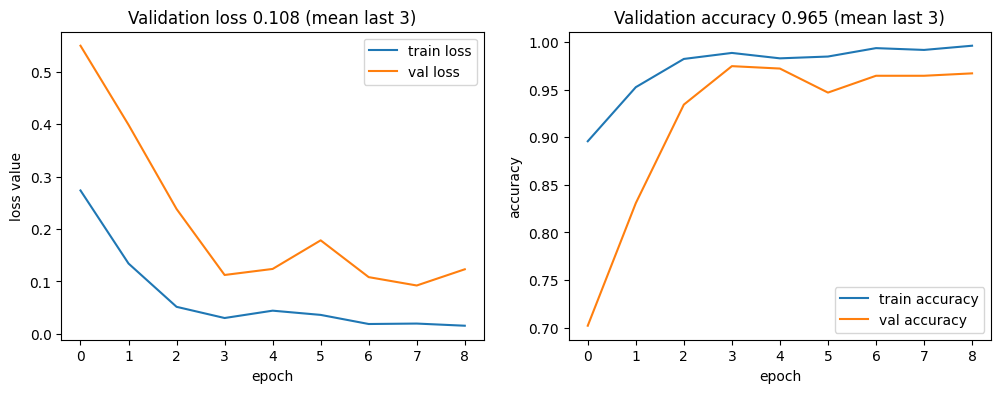

In [30]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

Save the model

In [42]:
with open(join(MODELS_PATH, 'transfer_mobilenet.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluate

In [52]:
# Load the data prepared in previous notebook
with np.load(join(DATA_PATH, 'test_data.npz')) as data:
    data_dict=dict(data.items())
X_test = data_dict['X']
y_test = data_dict['y']

In [53]:
# One-hot encode the labels
classes_test, y_test_classes = np.unique(y_test, return_inverse=True)
y_test = to_categorical(y_test_classes, num_classes=output_classes)    

In [54]:
%%time

# number of times the accuracy tests should be repeated
NUM_TESTS = 10

model_name = 'transfer'
for _ in range(NUM_TESTS):

    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = model.evaluate(X_test, y_test, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9559 - loss: 0.1459 
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9559 - loss: 0.1459
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9559 - loss: 0.1459
CPU times: user 4min 33s, sys: 6.41 s, total: 4min 40s
Wall time: 37.2 s


Averages per sample

In [64]:
avg_df = pd.DataFrame(columns=['model', 'average accuracy', 'average time'])
def get_eval_avg(model):
    acc_avg = eval_pd[eval_pd.model==model].accuracy.mean()
    time_avg = eval_pd[eval_pd.model==model].CPU_time.mean()/X_test.shape[0]
    return acc_avg, time_avg
acc_avg, time_avg = get_eval_avg('dummy')
avg_df.loc[len(avg_df)] = {'model': 'Dummy' , 'average accuracy': acc_avg, 'average time': time_avg}
#acc_avg, time_avg = get_eval_avg('svn')
#avg_df.loc[len(avg_df)] = {'model': 'Support Vector Machine' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('transfer')
avg_df.loc[len(avg_df)] = {'model': 'Transfer MobileNet' , 'average accuracy': acc_avg, 'average time': time_avg}

In [65]:
avg_df

,model,average accuracy,average time
0,Dummy,0.229798,0.042652
1,Transfer MobileNet,0.968182,0.042430
